# Tracing the Evolution of AI Coverage in the New York Times (2000–2024)

This notebook analyzes AI-related media coverage trends using:
- Temporal article frequency
- Sentiment evolution
- Calibration with non-AI topics

In [1]:
import pandas as pd

# Load the preprocessed AI articles
df_ai = pd.read_csv('../data/nyt-ai-sentiment.csv')

# Convert date and extract year
df_ai['pub_date'] = pd.to_datetime(df_ai['pub_date'], errors='coerce')
df_ai = df_ai.dropna(subset=['pub_date'])
df_ai['year'] = df_ai['pub_date'].dt.year

df_ai.head()

,pub_date,text,sentiment,sentiment_score,year
0,2000-02-03 05:00:00+00:00,"Hospitals nationwide, faced with growing conce...",neutral,0.677050,2000
1,2000-06-18 05:00:00+00:00,Gerald Jonas reviews books Evolution's Darling...,neutral,0.637411,2000
2,2000-07-25 05:00:00+00:00,Dr David B Fogel describes how computer progra...,neutral,0.595081,2000
3,2000-07-29 05:00:00+00:00,Correction of July 17 article on Microsoft's p...,neutral,0.569639,2000
4,2000-09-10 05:00:00+00:00,London Science Museum opens addition that expl...,neutral,0.819440,2000


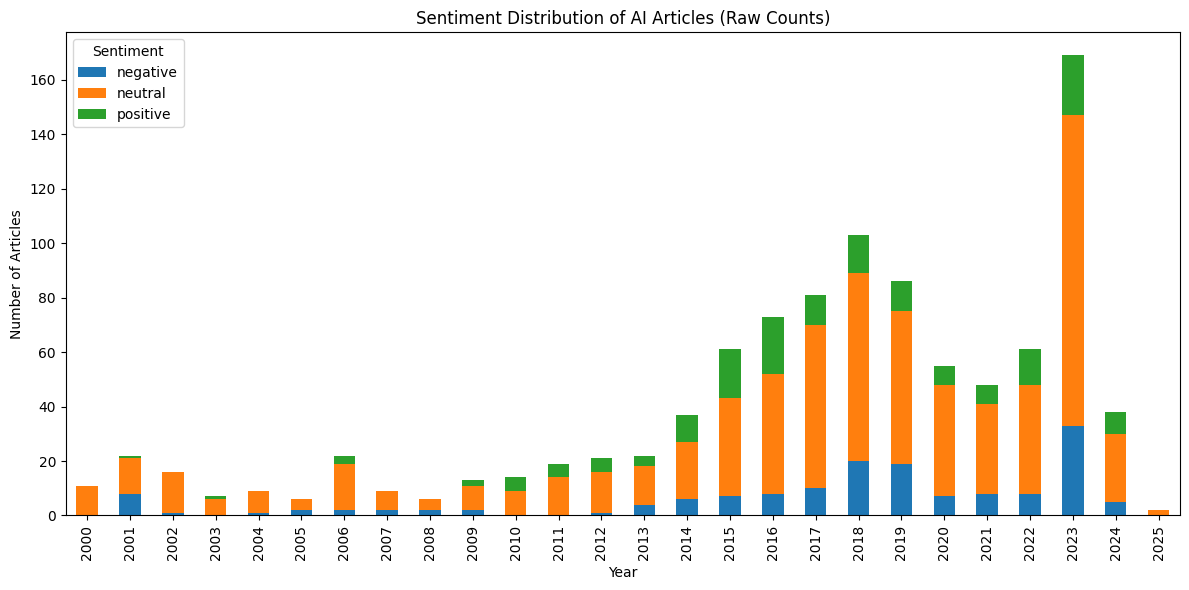

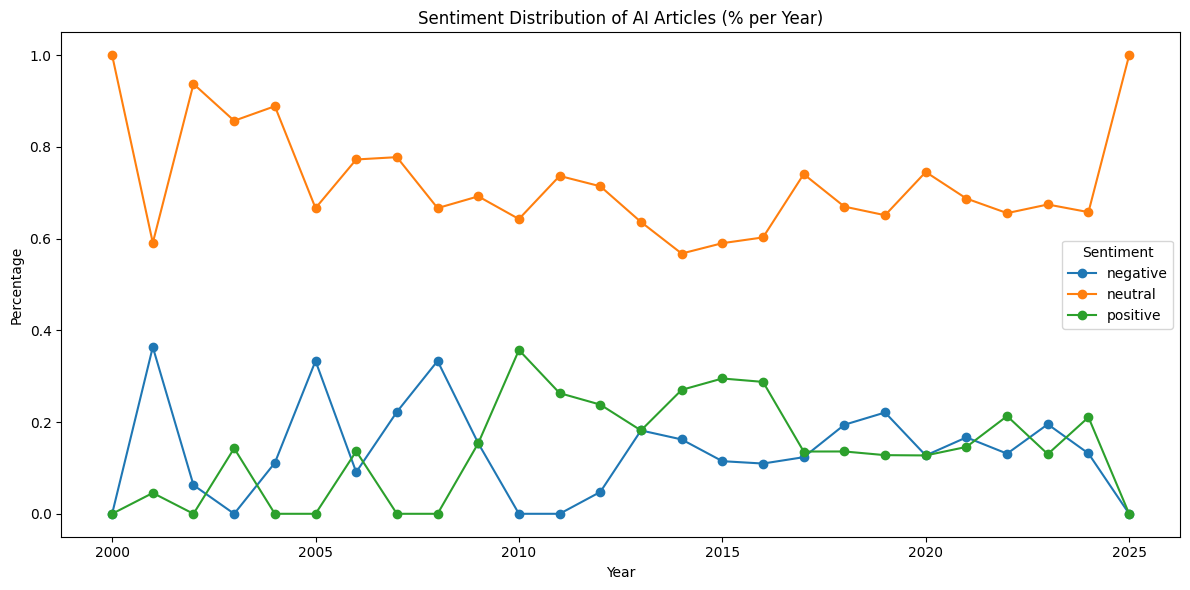

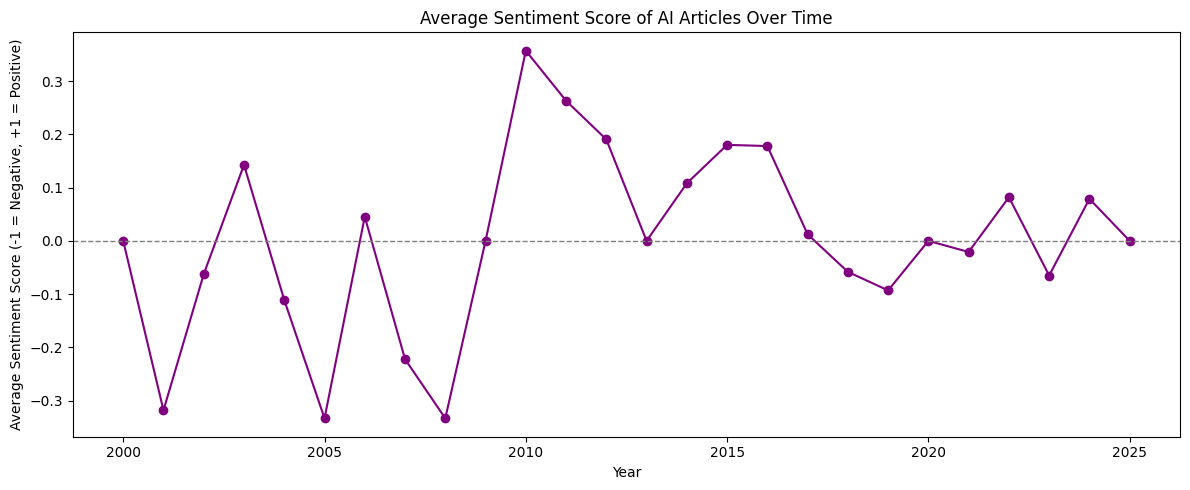

In [2]:
import matplotlib.pyplot as plt

# Ensure required columns exist
assert 'year' in df_ai.columns and 'sentiment' in df_ai.columns, "Missing expected columns."

# Map sentiment labels to numeric scores for weighted trends
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df_ai['sentiment_score_mapped'] = df_ai['sentiment'].map(sentiment_map)

# 1. Count sentiment categories per year
sentiment_counts = df_ai.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

# 2. Normalize to percentages per year
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# 3. Compute average sentiment score per year
avg_score_per_year = df_ai.groupby('year')['sentiment_score_mapped'].mean()

# -------- Plot 1: Absolute number of articles per sentiment --------
plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Sentiment Distribution of AI Articles (Raw Counts)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# -------- Plot 2: Sentiment percentages over time --------
plt.figure(figsize=(12, 6))
sentiment_percentages.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Sentiment Distribution of AI Articles (% per Year)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# -------- Plot 3: Average sentiment score over time --------
plt.figure(figsize=(12, 5))
avg_score_per_year.plot(kind='line', marker='o', color='purple')
plt.title('Average Sentiment Score of AI Articles Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score (-1 = Negative, +1 = Positive)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


## Normalized Frequency of AI-related Articles Over Time

In this section, we analyze how the relative importance of AI in New York Times coverage has evolved between 2000 and 2024.

To avoid misleading conclusions based on raw article counts (which can fluctuate due to changing publication volume), we compute the **percentage of AI-related articles per year**, normalized by the total number of NYT articles published in that year.

Key steps:
- Re-load the full `nyt-metadata.csv` file (not just filtered AI articles).
- Re-apply the AI detection logic used in preprocessing.
- Calculate and plot both:
  - Absolute number of AI vs. total articles.
  - **Percentage of AI coverage** (AI articles / total articles × 100).

This normalization helps address the calibration feedback we received, ensuring that increases in AI mentions are not simply due to overall growth in media output.


C:\Users\bogda\AppData\Local\Temp\ipykernel_28968\1806976611.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('../data/nyt-metadata.csv')


Detecting AI-related articles...


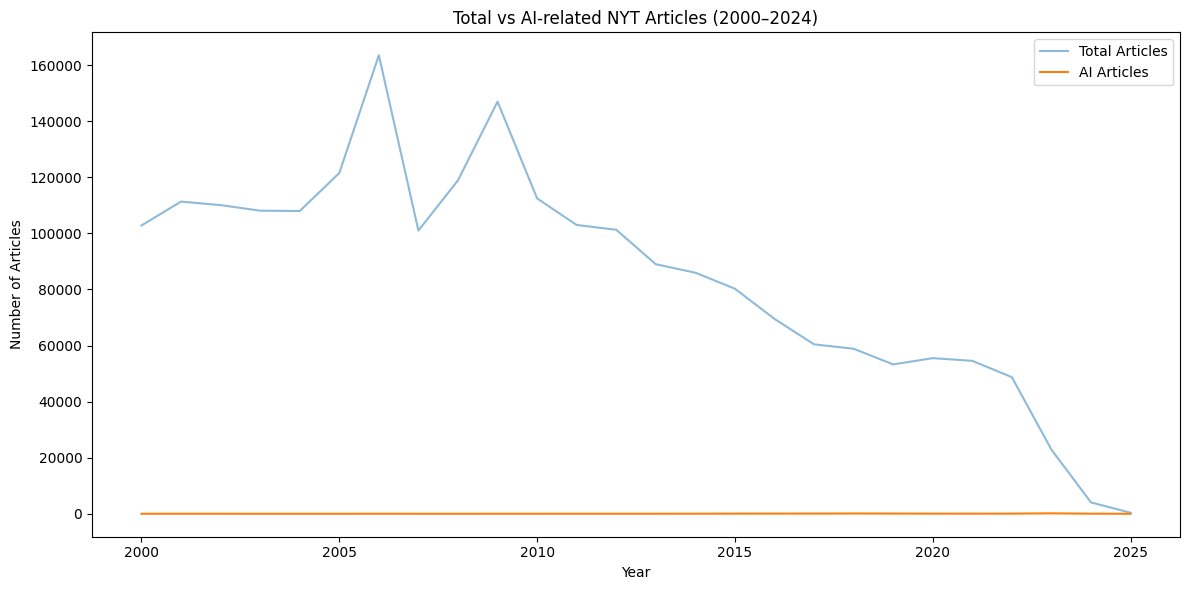

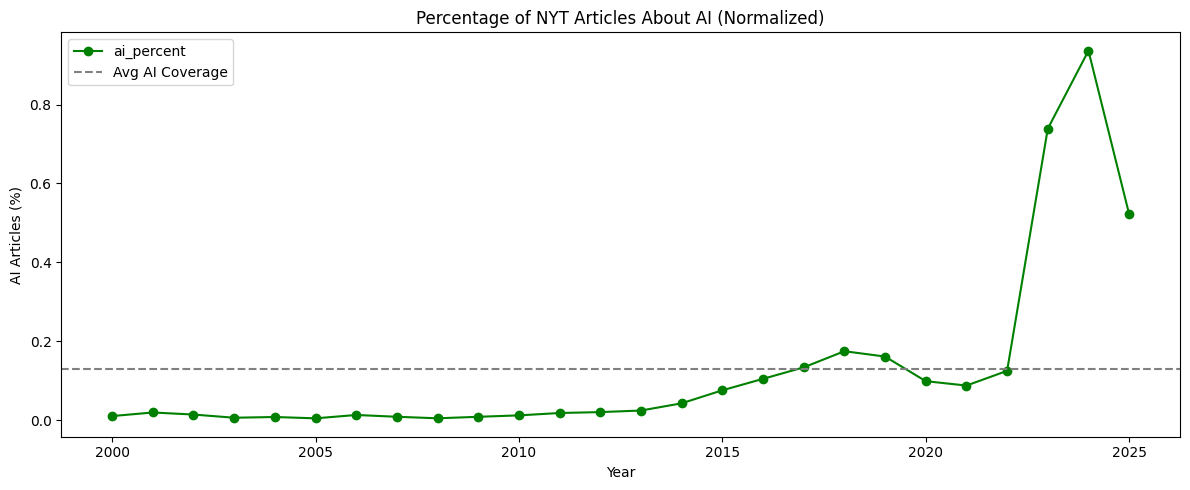

In [3]:
import re

# Load all NYT metadata
df_all = pd.read_csv('../data/nyt-metadata.csv')

# Parse publication date
df_all['pub_date'] = pd.to_datetime(df_all['pub_date'], errors='coerce')
df_all = df_all.dropna(subset=['pub_date'])
df_all['year'] = df_all['pub_date'].dt.year

# Combine relevant text fields (same logic as in your script)
text_columns = ['abstract', 'lead_paragraph', 'snippet', 'headline']
df_all['text'] = ''
for col in text_columns:
    if col in df_all.columns:
        df_all['text'] += ' ' + df_all[col].fillna('')
df_all['text'] = df_all['text'].str.strip()

# Define AI detection function again (simplified copy from your script)
def is_ai_related_article(text):
    if text is None or pd.isna(text) or text.strip() == '':
        return False
    text = text.lower()
    for term in ['artificial intelligence', 'machine learning', 'deep learning', 'neural network', 'neural networks']:
        if term in text:
            return True
    ai_matches = re.finditer(r'\b(ai)\b', text)
    context_words = ['technology', 'computer', 'algorithm', 'model', 'system', 'research', 'robot', 'automated', 'smart', 'intelligent']
    for match in ai_matches:
        start = max(0, match.start() - 50)
        end = min(len(text), match.end() + 50)
        context = text[start:end]
        for context_word in context_words:
            if context_word in context:
                return True
        if re.search(r'ai (system|model|algorithm|technology|research|program|tool)', context):
            return True
        if re.search(r'(use of|using|powered by|based on) ai', context):
            return True
    return False

# Detect AI-related articles (can take a few minutes)
print("Detecting AI-related articles...")
df_all['is_ai'] = df_all['text'].apply(is_ai_related_article)

# Aggregate yearly counts
yearly_counts = df_all.groupby('year').agg(
    total_articles=('text', 'count'),
    ai_articles=('is_ai', 'sum')
)

# Calculate normalized AI percentage
yearly_counts['ai_percent'] = yearly_counts['ai_articles'] / yearly_counts['total_articles'] * 100

# -------- Plot 1: Raw AI vs total articles --------
plt.figure(figsize=(12, 6))
yearly_counts['total_articles'].plot(label='Total Articles', alpha=0.5)
yearly_counts['ai_articles'].plot(label='AI Articles')
plt.title('Total vs AI-related NYT Articles (2000–2024)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend()
plt.tight_layout()
plt.show()

# -------- Plot 2: Percentage of AI articles --------
plt.figure(figsize=(12, 5))
yearly_counts['ai_percent'].plot(marker='o', color='green')
plt.title('Percentage of NYT Articles About AI (Normalized)')
plt.xlabel('Year')
plt.ylabel('AI Articles (%)')
plt.axhline(y=yearly_counts['ai_percent'].mean(), color='gray', linestyle='--', label='Avg AI Coverage')
plt.legend()
plt.tight_layout()
plt.show()


## AI vs Other Topics in NYT

Other topics (Politics, Health, Business, Sports, and non-AI Tech) are detected using keyword-based matching on the original dataset. For each topic, we calculate the percentage of total NYT articles in a given year that relate to it.

This gives a calibrated view of how AI coverage compares to other dominant themes in the media over time.


C:\Users\bogda\AppData\Local\Temp\ipykernel_28968\3833636187.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('../data/nyt-metadata.csv')


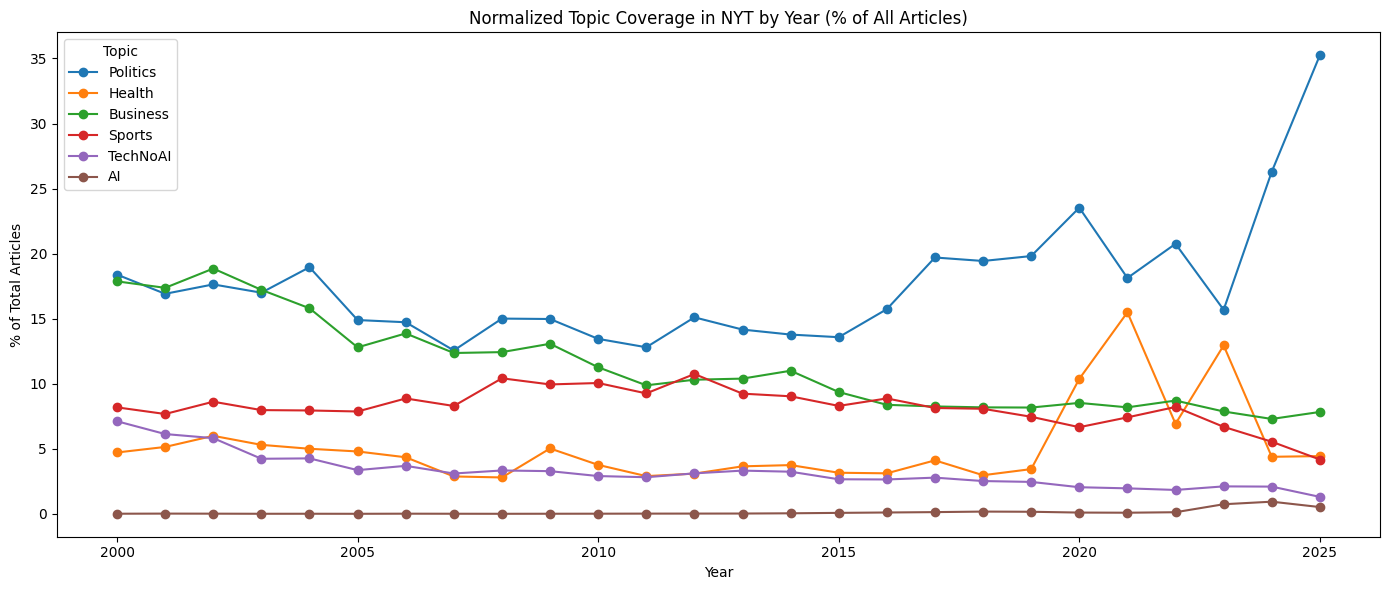

In [4]:
# Load sentiment-labeled AI articles with year info
df_ai = pd.read_csv('../data/nyt-ai-sentiment.csv')
df_ai['pub_date'] = pd.to_datetime(df_ai['pub_date'], errors='coerce')
df_ai = df_ai.dropna(subset=['pub_date'])
df_ai['year'] = df_ai['pub_date'].dt.year

# Reload full NYT dataset
df_all = pd.read_csv('../data/nyt-metadata.csv')
df_all['pub_date'] = pd.to_datetime(df_all['pub_date'], errors='coerce')
df_all = df_all.dropna(subset=['pub_date'])
df_all['year'] = df_all['pub_date'].dt.year
df_all['text'] = ''
for col in ['abstract', 'lead_paragraph', 'snippet', 'headline']:
    if col in df_all.columns:
        df_all['text'] += ' ' + df_all[col].fillna('')
df_all['text'] = df_all['text'].str.strip()

# Add AI flag based on previously filtered articles
ai_counts = df_ai.groupby('year').size().to_frame(name='AI')

# Define non-AI topic keywords
TOPIC_KEYWORDS = {
    "Politics": ['election', 'government', 'senate', 'congress', 'policy', 'president', 'campaign'],
    "Health": ['health', 'medicine', 'covid', 'vaccine', 'disease', 'hospital', 'mental health'],
    "Business": ['stock', 'market', 'economy', 'business', 'finance', 'company'],
    "Sports": ['game', 'team', 'player', 'season', 'nba', 'football', 'world cup', 'olympics'],
    "TechNoAI": ['technology', 'computer', 'software', 'internet', 'gadget', 'innovation', 'robotic']
}

# Detect non-AI topics
for topic, keywords in TOPIC_KEYWORDS.items():
    pattern = r'\b(?:' + '|'.join(re.escape(k) for k in keywords) + r')\b'
    df_all[f'is_{topic}'] = df_all['text'].str.contains(pattern, case=False, na=False)

# Count total articles per year
total_articles_per_year = df_all.groupby('year')['text'].count().to_frame(name='Total')

# Count other topics
topic_counts = df_all.groupby('year')[[f'is_{topic}' for topic in TOPIC_KEYWORDS]].sum()
topic_counts.columns = [topic for topic in TOPIC_KEYWORDS]

# Combine all topic counts, including AI
topic_counts = topic_counts.join(ai_counts, how='outer').fillna(0).astype(int)
topic_counts = topic_counts.join(total_articles_per_year, how='inner')

# Normalize to %
topic_percent = topic_counts.div(topic_counts['Total'], axis=0) * 100
topic_percent = topic_percent.drop(columns='Total')

# Plot
plt.figure(figsize=(14, 6))
topic_percent.plot(marker='o', ax=plt.gca())
plt.title('Normalized Topic Coverage in NYT by Year (% of All Articles)')
plt.ylabel('% of Total Articles')
plt.xlabel('Year')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()
